<center>

# Compulsory Assignment 2 

## Natural Language Processing [KAN - CSCO1002U]
<center>

##  0. Importing Modules 

In [123]:
import pandas as pd 
import numpy as np
import matplotlib as plt
import seaborn as sns 
import matplotlib.pyplot as plt
import gensim.downloader as api
import nltk
import re
import gensim

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 1. Importing the Data 

In [14]:
# Loading the data 
df = pd.read_csv("C:/Users/fredr/Downloads/archive (4)/articles1.csv")
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [47]:
# Removing columns 
df.drop(df.columns[[0,1,2,4,5,6,7,8]], axis = 1, inplace = True)
df.head()

,publication,content,vec
0,New York Times,washington congressional republican new fear c...,"[-0.17332134824810605, 0.11185025687169547, -0..."
1,New York Times,bullet shell get counted blood dry votive cand...,"[-0.16600878748815556, 0.11114715075815068, -0..."
2,New York Times,walt disney bambi opened 1942 critic praised s...,"[-0.1674998394854657, 0.1068369960372066, -0.0..."
3,New York Times,death may great equalizer isnt necessarily eve...,"[-0.16766362141574678, 0.11295927208789244, -0..."
4,New York Times,seoul south korea north korea leader kim said ...,"[-0.17512250354742953, 0.11245045831158663, -0..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   publication  50000 non-null  object
 1   content      50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Text(0.5, 1.0, 'Publication Value Counts')

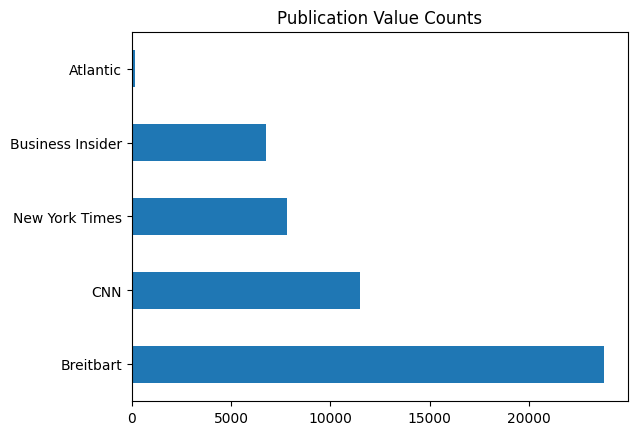

In [6]:
# Countplot shows the distribution of Publication
df['publication'].value_counts().plot(kind ='barh').set_title('Publication Value Counts')

In [69]:
# Function for Cleaning text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Tokenize the article into words
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens 
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a cleaned article
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [71]:
# Cleaning the text
df['content'] = df['content'].apply(clean)

In [72]:
df.head()

,publication,content,vec,label_num,tokens
0,New York Times,washington congressional republican new fear c...,"[-0.17332134824810605, 0.11185025687169547, -0...",4,"[washington, congressional, republican, new, f..."
1,New York Times,bullet shell get counted blood dry votive cand...,"[-0.16600878748815556, 0.11114715075815068, -0...",4,"[bullet, shell, get, counted, blood, dry, voti..."
2,New York Times,walt disney bambi opened 1942 critic praised s...,"[-0.1674998394854657, 0.1068369960372066, -0.0...",4,"[walt, disney, bambi, opened, 1942, critic, pr..."
3,New York Times,death may great equalizer isnt necessarily eve...,"[-0.16766362141574678, 0.11295927208789244, -0...",4,"[death, may, great, equalizer, isnt, necessari..."
4,New York Times,seoul south korea north korea leader kim said ...,"[-0.17512250354742953, 0.11245045831158663, -0...",4,"[seoul, south, korea, north, korea, leader, ki..."


## 2. Word Embeddings

### 2.1 Bag of Words 

In [104]:
# CountVectorizer 
BoW = CountVectorizer()
BoW.fit(df['content'])

CountVectorizer()

### 2.2 Word2Vect - Trained on our own data

In [110]:
# Tokenizing the cleaned text
text = df['content']
tokens = text.apply(word_tokenize)

In [124]:
# Training the Word2Vec model 
wvT = Word2Vec(tokens, 
               vector_size = 100, 
               window = 5, 
               min_count = 2, 
               workers = 4)

In [134]:
# Function for vectorizing the text
def vectorize(tokens):
    words = tokens.split()
    words_vecs = [wvT.wv[word] for word in words if word in wvT.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

### 2.3 Word2Vec - Trained by Google

In [108]:
# Google trained one 
wvG = api.load('word2vec-google-news-300')

In [117]:
# Function for computing the average vector 
# Gathered from Exercise 8

def avg_feature_vector(words, model, num_features):
    n_words = 0
    feature_vec = np.zeros((num_features, ), dtype='float32')
    for word in words:
        try:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
        except KeyError:
            pass
    if n_words == 0:
        return feature_vec
    else:
        return feature_vec / n_words


### Text Classification 

In [17]:
# Evaluation function that prints classification report and confusion matrix
def evaluate(y_test, y_pred, model_name):
    '''
    Function for Evaluating a model
    Prints out:
    --- Classification Report 
    --- Confusion Matrix
    '''
    
    print(f"\033[34m{model_name}\033[0m")
    
    #print accuracy
    cm = confusion_matrix(y_test, y_pred)
    print(f" \033[32mClassification Report:\033[0m")
    print(classification_report(y_test, y_pred, zero_division=False))
    print(f" \033[32mConfusion Matrix:\033[0m")
    
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f'{model_name}: Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#### Logistic Regression with Bag of Words

In [105]:
# Extracting features and content - Can not use tokens for this 
y = df['publication']
X = df['content']

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

Logistic Regression with BoW
 Classification Report:
                  precision    recall  f1-score   support

        Atlantic       0.57      0.23      0.33        35
       Breitbart       0.92      0.94      0.93      4655
Business Insider       0.79      0.81      0.80      1413
             CNN       0.89      0.88      0.89      2337
  New York Times       0.94      0.91      0.93      1560

        accuracy                           0.90     10000
       macro avg       0.82      0.75      0.77     10000
    weighted avg       0.90      0.90      0.90     10000

 Confusion Matrix:


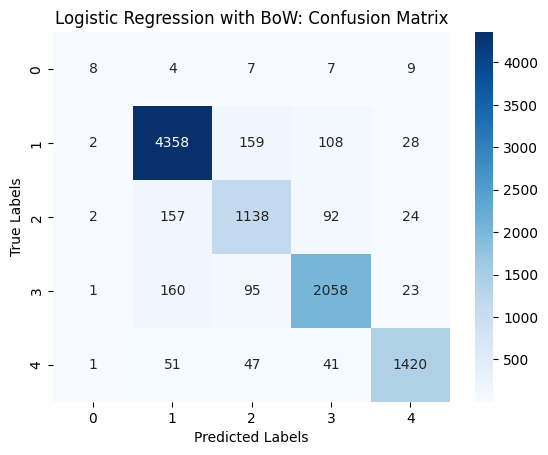

In [107]:
# Vectorizer 
X_train_bow = BoW.transform(X_train)
X_test_bow = BoW.transform(X_test)

# Classifier 
lr_bow = LogisticRegression(max_iter=1000000)
lr_bow.fit(X_train_bow, y_train)

# Evaluate
yPred_bow = lr_bow.predict(X_test_bow)
evaluate(y_test, yPred_bow, 'Logistic Regression with BoW')

#### Logistic Regression with own trained Word2Vec embeddings 

In [135]:
# Splitting the data 
X_train_wvT, X_test_wvT, y_train_wvT, y_test_wvT = train_test_split(
    X, y, test_size=0.2, random_state=9)

In [138]:
# Vectorizing
X_train_wvT = np.array([vectorize(tokens) for tokens in X_train])
X_test_wvT = np.array([vectorize(tokens) for tokens in X_test])

Logisitic Regression with own W2V
 Classification Report:
                  precision    recall  f1-score   support

        Atlantic       0.00      0.00      0.00        35
       Breitbart       0.77      0.86      0.81      4655
Business Insider       0.67      0.44      0.53      1413
             CNN       0.64      0.65      0.64      2337
  New York Times       0.75      0.73      0.74      1560

        accuracy                           0.73     10000
       macro avg       0.57      0.54      0.55     10000
    weighted avg       0.72      0.73      0.72     10000

 Confusion Matrix:


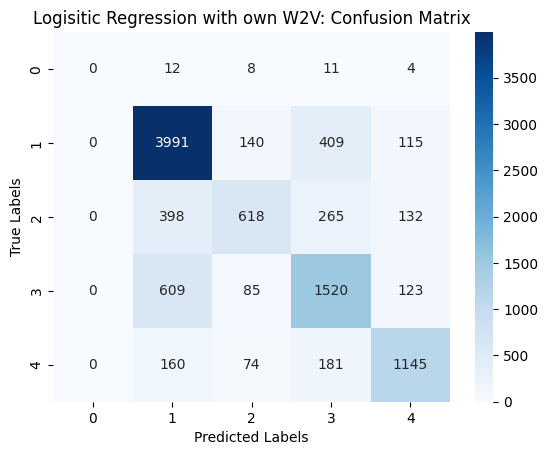

In [139]:
# Classifier 
lr_wvT = LogisticRegression(max_iter=1000000)
lr_wvT.fit(X_train_wvT, y_train_wvT)

# Evaluate
yPred_wvT = lr_wvT.predict(X_test_wvT)
evaluate(y_test_wvT, yPred_wvT, 'Logisitic Regression with own W2V')

#### Logistic Regression with Google trained Word2Vec embeddings

In [118]:
# Constructing average vectors 
# Gathered from Exercise 8 

features = []
vectorsize = 300
for t in tokens:
    features.append(avg_feature_vector(t, wvG, vectorsize))    

In [119]:
# Splitting the data
Train_features, Test_features, Train_labels, Test_labels = train_test_split(
    features, df['publication'], 
    test_size=0.2,
    random_state=9)

Logistic Regression with Google W2V
 Classification Report:
                  precision    recall  f1-score   support

        Atlantic       0.00      0.00      0.00        35
       Breitbart       0.74      0.89      0.80      4655
Business Insider       0.72      0.43      0.54      1413
             CNN       0.63      0.59      0.61      2337
  New York Times       0.80      0.71      0.75      1560

        accuracy                           0.72     10000
       macro avg       0.58      0.52      0.54     10000
    weighted avg       0.72      0.72      0.71     10000

 Confusion Matrix:


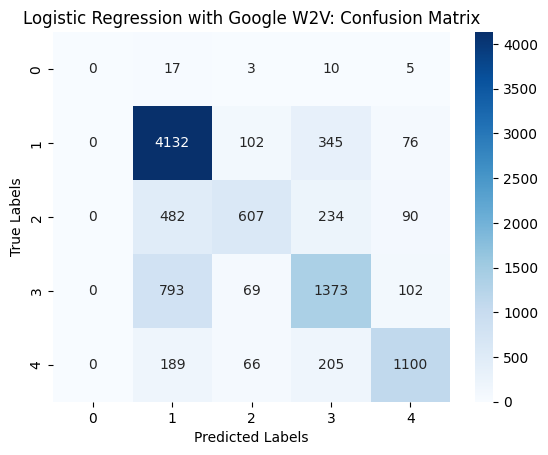

In [120]:
# Classification Model 
lr_wvG = LogisticRegression(max_iter=1000000)
lr_wvG.fit(Train_features, Train_labels)

# Evaluate
yPred_wvG = lr_wvG.predict(Test_features)
evaluate(Test_labels, yPred_wvG, 'Logistic Regression with Google W2V')